# stock2vec

Create vectors for stocks based on their relative volatility.

In [12]:
import csv
import datetime
import math
import multiprocessing as mp
import numpy as np
import pandas as pd
import os
import random
import sys
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import time
from functools import partial
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
%matplotlib notebook

Load the diluted earnings per share by ticker.

In [2]:
CSV_URL = 'SEE_PREPROCESSING_NOTEBOOK'
FILE_NAME = 'input/prices.csv'
LOG_DIR = 'output'
MODEL_PATH = os.path.join(LOG_DIR, "model.ckpt")
STOCK_PATH = os.path.join(LOG_DIR,'stock.tsv')

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir

if not os.path.exists('input'):
    os.makedirs('input')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(FILE_NAME):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Prices') as pbar:
        urlretrieve(CSV_URL, FILE_NAME, pbar.hook)

Prices: 485MB [00:36, 13.1MB/s]                               


In [4]:
chunksize = 1000000
price_rows = 9191528

price_reader = pd.read_csv('input/prices.csv', 
                      header=None,
                      parse_dates=[1],
                      chunksize=chunksize, 
                      iterator=True)

df_prices = pd.DataFrame()

with tqdm(total=price_rows, desc='rows') as pbar:
    for chunk in price_reader:
        df_prices = df_prices.append(chunk)
        pbar.update(chunksize);

df_prices.columns = ['adj_close', 'date', 'ticker', 'epsdil', 'pe']

# Sort by date, then ticker
df_prices.sort_values(['date', 'pe'], inplace=True)

print(df_prices.head())

prices = df_prices['adj_close'].values.tolist()
dates = df_prices['date'].values.tolist()
tickers = df_prices['ticker'].values.tolist()
pes = df_prices['pe'].values.tolist()

rows: 10000000it [00:13, 784808.61it/s]                            


         adj_close       date ticker  epsdil         pe
45526    13.745073 2001-06-18   OLED   -0.87 -15.798935
3046709   6.147269 2001-06-18    YUM    0.69   8.909085
1778402  43.419875 2001-06-18    SWY    2.31  18.796483
315864   29.645033 2001-06-18    PEP    1.50  19.763356
1743245  11.213455 2001-06-18    SVU    0.47  23.858415


<IPython.core.display.Javascript object>


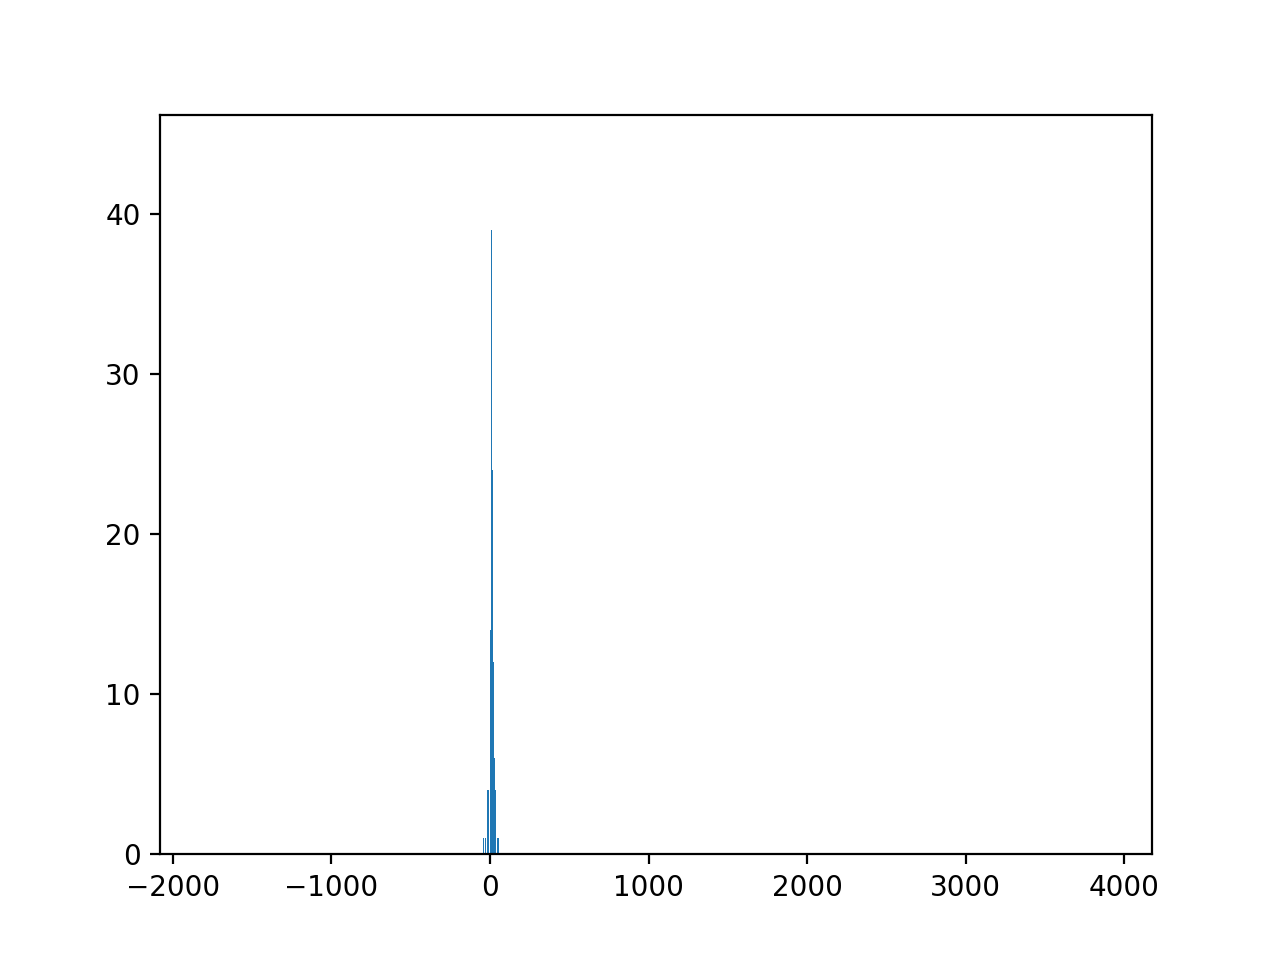

In [13]:
day = df_prices[(df_prices['date'] > datetime.date(year=2001,day=3,month=3)) & (df_prices['date'] < datetime.date(year=2002,day=3,month=3))]['pe'].tolist()

frequency = {}

for pe in day:
    rounded_pe = int(round(pe))
    freq = frequency.get(rounded_pe, 0)
    frequency[rounded_pe] = freq + 1

for k,v in frequency.items():
    frequency[k] = int(frequency[k] / 250)
    
plt.bar(list(frequency.keys()), frequency.values(), align='center')

plt.show()

## Build context

For each stock, find C stocks that have the closest volatility to that ticker for that day.

In [6]:
ticker_to_int = {}
int_to_ticker = {}

def get_ticker_int(idx):
    ticker = tickers[idx]
    key = ticker_to_int.get(ticker, None)
    if key is None:
        key = ticker_to_int[ticker] = len(ticker_to_int)
        int_to_ticker[key] = ticker
    return key

def get_window(idx, total, window_size=5):
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R if (idx + R) < total else total

    stock_int = get_ticker_int(idx)
    stock_date = dates[idx]
    
    window = [] 
    
    for i in range(start, stop):
        nearby_stock_int = get_ticker_int(i)
        nearby_stock_date = dates[i]
        if nearby_stock_int != stock_int and nearby_stock_date == stock_date:
            window.append(nearby_stock_int)
    
    return window

for idx in range(0, 20, 9):
    print('window for', idx, tickers[idx], get_ticker_int(idx))
    for nearby_int in get_window(idx, len(tickers), 5):
        print(nearby_int, int_to_ticker[nearby_int])

window for 0 OLED 0
1 YUM
2 SWY
3 PEP
4 SVU
window for 9 SVU 4
0 OLED
1 YUM
2 SWY
3 PEP
window for 18 PEP 3
2 SWY


In [7]:
batch_size = 10000
window_size = 10

total_prices = len(prices)

pbar = tqdm(total=int(total_prices / batch_size))

def get_batch(start):
    x, y = [], []

    stop = start + batch_size if (start + batch_size) < total_prices else total_prices

    for i in range(start, stop):
        batch_x = get_ticker_int(i)
        batch_y = get_window(i, total_prices, window_size)
        y.extend(batch_y)
        x.extend([batch_x]*len(batch_y))

    pbar.update();

    return [x, y]

def get_batches():
    batches = []
    
    for start in range(0, total_prices, batch_size):
        batches.append(get_batch(start))
   
    return batches

batches = get_batches()

100%|██████████| 919/919 [01:39<00:00,  9.27it/s]

In [15]:
# Save embedding metadata
with open(STOCK_PATH, 'w') as out:
  out.write('\n'.join(int_to_ticker.values()))

## Build the Graph

In [14]:
n_embedding = 50 # Number of embedding features 
n_stocks = len(df_prices['ticker'].unique())

train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
    embedding = tf.Variable(tf.random_uniform((n_stocks, n_embedding), -1, 1), name='stock_embedding')
    embed = tf.nn.embedding_lookup(embedding, inputs)

# Negative sampling

In [16]:
# Number of negative labels to sample
n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_stocks, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_stocks))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_stocks)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [17]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

# Training

In [ ]:
epochs = 20

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        start = time.time()
        for batch in batches:
            x = batch[0]
            y = batch[1]
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 10000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_stock = int_to_ticker[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_stock
                    for k in range(top_k):
                        try:
                            close_stock = int_to_ticker[nearest[k]]
                            log = '%s %s,' % (log, close_stock)
                        except Exception:
                            print('nearest[k]', nearest[k])
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, MODEL_PATH)
    embed_mat = sess.run(normalized_embedding)

Epoch 1/20 Iteration: 100 Avg. Training loss: 4.5168 0.1068 sec/batch
Epoch 1/20 Iteration: 200 Avg. Training loss: 4.2953 0.1026 sec/batch
Epoch 1/20 Iteration: 300 Avg. Training loss: 4.1577 0.1006 sec/batch
Epoch 1/20 Iteration: 400 Avg. Training loss: 4.0547 0.1018 sec/batch
Epoch 1/20 Iteration: 500 Avg. Training loss: 4.0295 0.1044 sec/batch
Epoch 1/20 Iteration: 600 Avg. Training loss: 3.8883 0.0993 sec/batch
Epoch 1/20 Iteration: 700 Avg. Training loss: 3.8033 0.0987 sec/batch
Epoch 1/20 Iteration: 800 Avg. Training loss: 3.7277 0.1019 sec/batch
Epoch 1/20 Iteration: 900 Avg. Training loss: 3.7987 0.1011 sec/batch
Epoch 2/20 Iteration: 1000 Avg. Training loss: 4.2752 0.0814 sec/batch
Epoch 2/20 Iteration: 1100 Avg. Training loss: 4.0082 0.1055 sec/batch
Epoch 2/20 Iteration: 1200 Avg. Training loss: 3.8316 0.1014 sec/batch
Epoch 2/20 Iteration: 1300 Avg. Training loss: 3.8532 0.0999 sec/batch
Epoch 2/20 Iteration: 1400 Avg. Training loss: 3.9195 0.1011 sec/batch
Epoch 2/20 Iter

In [22]:
# Save the embedding for tensorboard

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, MODEL_PATH)
    
    config = projector.ProjectorConfig()

    viz_embedding = config.embeddings.add()
    viz_embedding.tensor_name = embedding.name
    viz_embedding.metadata_path = STOCK_PATH
    summary_writer = tf.summary.FileWriter(LOG_DIR)
    projector.visualize_embeddings(summary_writer, config)

    saver.save(sess, MODEL_PATH)

In [23]:
from sklearn.manifold import TSNE

viz_stocks = 1000
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_stocks, :])

<IPython.core.display.Javascript object>


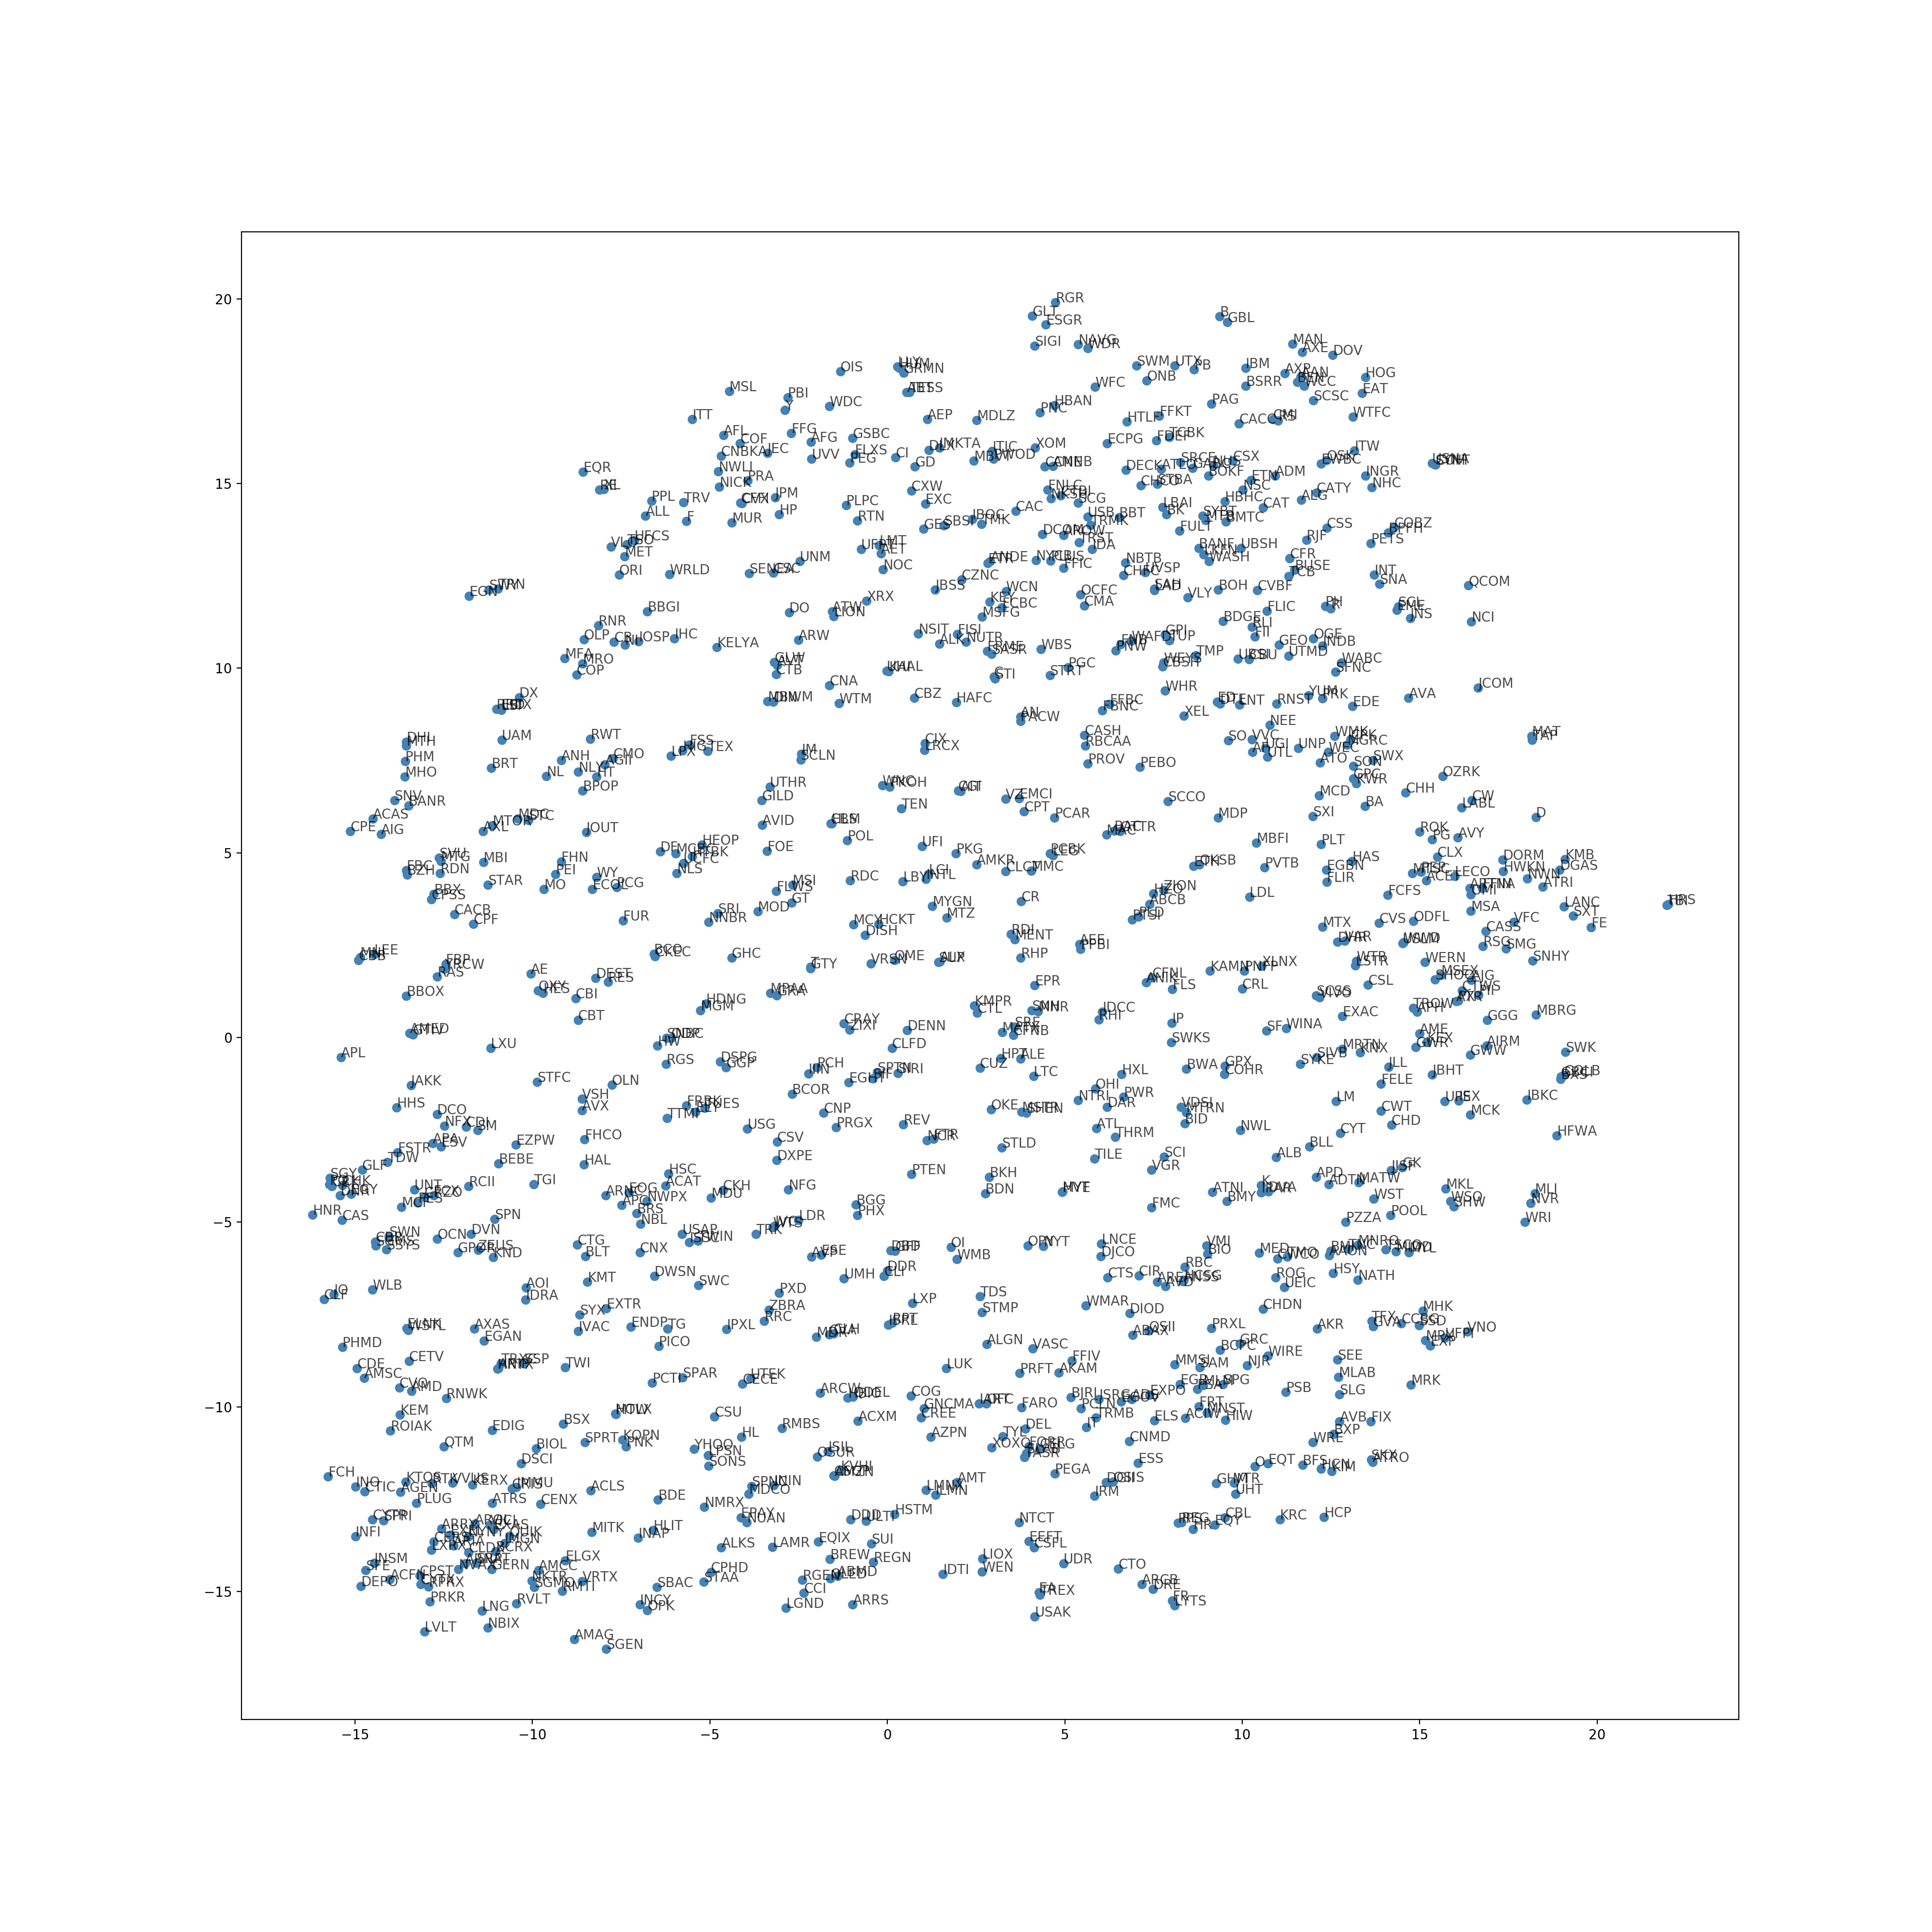

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
for idx in range(viz_stocks):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_ticker[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)